<a href="https://colab.research.google.com/github/Manditar2/NLI-con-red-neuronal-LSTM/blob/main/Proyecto_data_science.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.utils import pad_sequences
from keras.callbacks import TensorBoard, EarlyStopping
from keras.layers import Input, Embedding, LSTM , Dense, Flatten, Dropout , GRU, TimeDistributed, Conv1D, MaxPool1D
from keras.metrics import TruePositives, FalsePositives,categorical_accuracy, TrueNegatives, FalseNegatives, Precision, Recall, AUC



In [ ]:
nltk.download('stopwords')
!wget https://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


--2023-05-21 19:40:34--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-05-21 19:40:35--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.02MB/s    in 2m 39s  

2023-05-21 19:43:14 (5.17 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflatin

In [ ]:
#@title Cargar datos
df = pd.read_csv('/content/sample_data/snli_1.0_train.csv')
columnas = ['sentence1','sentence2','gold_label']
df = df[columnas]
df.dropna(axis=0, inplace=True) #Se eliminan datos nulos
df.head()

,sentence1,sentence2,gold_label
0,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,neutral
1,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",contradiction
2,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",entailment
3,Children smiling and waving at camera,They are smiling at their parents,neutral
4,Children smiling and waving at camera,There are children present,entailment


In [ ]:
df = df.loc[df['gold_label'] != "-"]   #Se botan las filas que contengan - y neutral
df = df.loc[df['gold_label'] != "neutral"]
df.shape

(163896, 3)

In [ ]:
df = df.sample(frac = 1)
df["gold_label"] = (df["gold_label"] == "contradiction").astype(int)
df.head()

,sentence1,sentence2,gold_label
76696,The teenager is attempting a skateboard trick ...,The teen is skateboarding outside.,0
49169,A crowd of people standing outside a building.,People stand outside a building.,0
51705,A man in a red jacket rides a horse in mountai...,A man is outdoors.,0
30828,A group of people waiting in a train station.,There are no people at the train station.,1
105653,A cook works hard as he takes food out of the ...,a person in a kitchen,0


In [ ]:
y = df['gold_label']
len(df)
X = df[['sentence1','sentence2']]

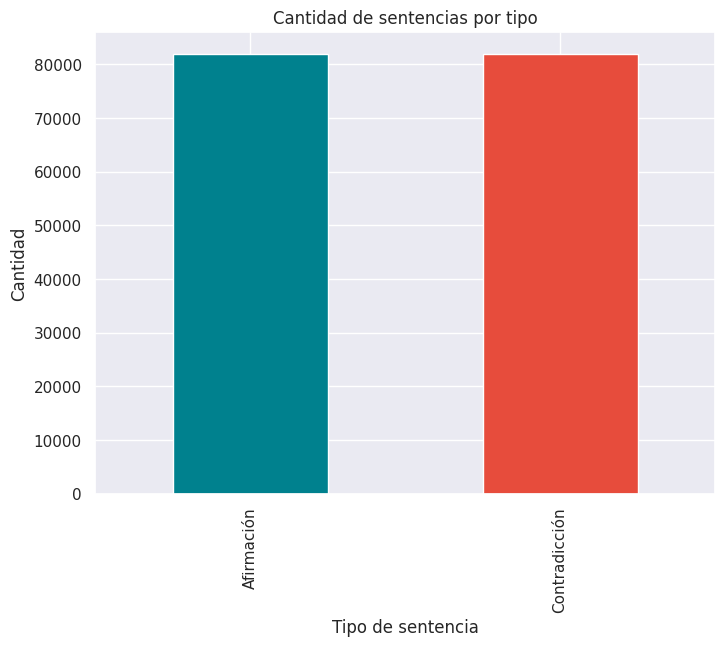

In [ ]:
sns.set(style='darkgrid')
colores = ['#00818E', '#e74c3c']
counts = df['gold_label'].value_counts().rename({0: 'Afirmación', 1: 'Contradicción'})

plt.figure(figsize=(8, 6))
counts.plot(kind='bar', color = colores)
plt.title('Cantidad de sentencias por tipo')
plt.xlabel('Tipo de sentencia')
plt.ylabel('Cantidad')
plt.show()

In [ ]:
#@title Limpieza de datos

def limpiarTexto(texto):
  texto = str(texto).lower()
  texto = re.sub('\[.*?\]', '', texto)
  texto = re.sub('<.*?>+', '', texto)
  texto = re.sub('\n', '', texto)
  texto = re.sub('[%s]' % re.escape(string.punctuation), '', texto)
  texto = re.sub('\w*\d\w*', '', texto)
  return texto

df.head()

,sentence1,sentence2,gold_label
76696,The teenager is attempting a skateboard trick ...,The teen is skateboarding outside.,0
49169,A crowd of people standing outside a building.,People stand outside a building.,0
51705,A man in a red jacket rides a horse in mountai...,A man is outdoors.,0
30828,A group of people waiting in a train station.,There are no people at the train station.,1
105653,A cook works hard as he takes food out of the ...,a person in a kitchen,0


In [ ]:
df['sentence1'] = df['sentence1'].apply(limpiarTexto)
df['sentence2'] = df['sentence2'].apply(limpiarTexto)
df.head()

,sentence1,sentence2,gold_label
76696,the teenager is attempting a skateboard trick ...,the teen is skateboarding outside,0
49169,a crowd of people standing outside a building,people stand outside a building,0
51705,a man in a red jacket rides a horse in mountai...,a man is outdoors,0
30828,a group of people waiting in a train station,there are no people at the train station,1
105653,a cook works hard as he takes food out of the ...,a person in a kitchen,0


In [ ]:
#@title Pre procesamiento
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text
  
df['sentence1'] = df['sentence1'].apply(remove_stopwords)
df['sentence2'] = df['sentence2'].apply(remove_stopwords)
df['sentence1'].shape
df['sentence2'].shape


(163896,)

In [ ]:
stemmer = nltk.SnowballStemmer('english')
def stematizar(texto):
  texto = ' '.join(stemmer.stem(word) for word in texto.split(' ')) #Divide el texto, y aplica la función de stematización a cada palabra
  return texto
df['sentence1'] = df['sentence1'].apply(stematizar)
df['sentence2'] = df['sentence2'].apply(stematizar)
df.head()


,sentence1,sentence2,gold_label
76696,teenag attempt skateboard trick local skate pa...,teen skateboard outsid,0
49169,crowd peopl stand outsid build,peopl stand outsid build,0
51705,man red jacket ride hors mountain terrain,man outdoor,0
30828,group peopl wait train station,peopl train station,1
105653,cook work hard take food oven,person kitchen,0


In [ ]:
df['sentence1'].shape
df['sentence2'].shape

(163896,)

In [ ]:
#@title Tokenización
sentencias_arreglo = np.asarray([df['sentence1'],df['sentence2']])
print(sentencias_arreglo)
sentencias_arreglo = sentencias_arreglo.reshape(-1,1)

[['teenag attempt skateboard trick local skate park surround palm tree'
  'crowd peopl stand outsid build'
  'man red jacket ride hors mountain terrain' ...
  'boy blue slide tan slide'
  'four peopl scuba dive swim pool two girl one bald man third person see arm'
  'small child cur hair ride toy']
 ['teen skateboard outsid' 'peopl stand outsid build' 'man outdoor' ...
  'girl blue slide tan slide' 'everyon pool femal'
  'littl boy ride surfboard']]


In [ ]:
sentencias_arreglo.shape

(327792, 1)

In [ ]:
print(sentencias_arreglo)

[['teenag attempt skateboard trick local skate park surround palm tree']
 ['crowd peopl stand outsid build']
 ['man red jacket ride hors mountain terrain']
 ...
 ['girl blue slide tan slide']
 ['everyon pool femal']
 ['littl boy ride surfboard']]


In [ ]:
sentencias_arreglo = sentencias_arreglo.reshape(sentencias_arreglo.shape[0])
sentencias_arreglo.shape

(327792,)

In [ ]:
print(sentencias_arreglo)

['teenag attempt skateboard trick local skate park surround palm tree'
 'crowd peopl stand outsid build'
 'man red jacket ride hors mountain terrain' ...
 'girl blue slide tan slide' 'everyon pool femal'
 'littl boy ride surfboard']


In [ ]:
tokenizar = Tokenizer(num_words = 6000)
tokenizar.fit_on_texts(sentencias_arreglo) #Transforma a "número" las palabras dentro del arreglo


AttributeError: ignored

In [ ]:
texto_original_seq = tokenizar.texts_to_sequences(df['sentence1']) #Guarda un arreglo que en vez de palabras, posee índices de palabras
texto_original = pad_sequences(texto_original_seq) #Agrega padding para estandarizar el tamaño
hipotesis_seq = tokenizar.texts_to_sequences(df['sentence2'])
hipotesis = pad_sequences(hipotesis_seq, maxlen = texto_original.shape[1])
print(hipotesis)

[[  0   0   0 ... 874 106  23]
 [  0   0   0 ...   8  23  45]
 [  0   0   0 ...   0   1  67]
 ...
 [  0   0   0 ... 232 281 232]
 [  0   0   0 ... 891 132 135]
 [  0   0   0 ...  11  31 575]]


In [ ]:
encoder = LabelEncoder()
etiquetas = df['gold_label']
etiquetas = encoder.fit_transform(etiquetas)
etiquetas

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
etiquetas = to_categorical(etiquetas)
etiquetas

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [ ]:
texto_original.shape

(163896, 45)

In [ ]:
hipotesis.shape

(163896, 45)

In [ ]:
data_tokenizada = np.asarray([texto_original,hipotesis])
data_tokenizada

array([[[   0,    0,    0, ...,  230,  892,   72],
        [   0,    0,    0, ...,    8,   23,   45],
        [   0,    0,    0, ...,  118,  146, 1389],
        ...,
        [   0,    0,    0, ...,  232,  281,  232],
        [   0,    0,    0, ...,   25,  534,  171],
        [   0,    0,    0, ...,   83,   31,  168]],

       [[   0,    0,    0, ...,  874,  106,   23],
        [   0,    0,    0, ...,    8,   23,   45],
        [   0,    0,    0, ...,    0,    1,   67],
        ...,
        [   0,    0,    0, ...,  232,  281,  232],
        [   0,    0,    0, ...,  891,  132,  135],
        [   0,    0,    0, ...,   11,   31,  575]]], dtype=int32)

In [ ]:
data_tokenizada.shape

(2, 163896, 45)

In [ ]:
data_tokenizada = data_tokenizada.reshape(data_tokenizada.shape[1], 2, data_tokenizada.shape[2])

ValueError: ignored

In [ ]:
tokenizar.word_index

In [ ]:
#@title Embedding
vocabulario = len(tokenizar.word_index)

def gloveWork(archivo,vocabulario):
  #Se crea un diccionario palabra-vector de un modelo preentrenado(Glove)
  embeddings_index = {}
  file_ = open(archivo)
  for line in file_:
      arr = line.split()
      palabra = arr[0]
      vector = np.asarray(arr[1:],dtype='float32')
      embeddings_index[palabra] = vector
  file_.close() 

  tam_maximo = vocabulario +1
  indices_palabras = tokenizar.word_index
  embedding_matriz = np.zeros((tam_maximo,300)).astype(object)

  for palabrax, indice in indices_palabras.items():
    vector_entrenado = embeddings_index.get(palabrax)
    if vector_entrenado is not None:
      embedding_matriz[indice] = vector_entrenado

  return embedding_matriz


In [ ]:
#@title Modelo
x = Input(shape=(data_tokenizada.shape[1], data_tokenizada.shape[2],))
p = TimeDistributed(Embedding(vocabulario + 1 , 300))(x)
p = TimeDistributed(LSTM(128, return_sequences=True))(p)
p = TimeDistributed(LSTM(64, return_sequences=True))(p)
x1 = TimeDistributed(tf.keras.layers.GlobalMaxPooling1D())(p)
x2 = TimeDistributed(tf.keras.layers.GlobalAveragePooling1D())(p)
concat = tf.keras.layers.concatenate([x1, x2])
p = tf.keras.layers.Dropout(0.35)(concat)
p = Flatten()(p)
p = Dense(2, activation="softmax")(p)

In [ ]:
m = tf.keras.models.Model(inputs = x, outputs = p)

In [ ]:
m.layers[1].set_weights([gloveWork("glove.6B.300d.txt", vocabulario)])

In [ ]:
m.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2, 45)]      0           []                               
                                                                                                  
 time_distributed (TimeDistribu  (None, 2, 45, 300)  4129500     ['input_1[0][0]']                
 ted)                                                                                             
                                                                                                  
 time_distributed_1 (TimeDistri  (None, 2, 45, 128)  219648      ['time_distributed[0][0]']       
 buted)                                                                                           
                                                                                              

In [ ]:
m.compile(loss="binary_crossentropy",optimizer='adam',metrics=[TruePositives(name='tp'),
                                                                     FalsePositives(name='fp'),
                                                                     TrueNegatives(name='tn'),
                                                                     FalseNegatives(name='fn'),
                                                                     "accuracy",
                                                                     Precision(name='precision'),
                                                                     Recall(name='recall'),
                                                                     AUC(name = "AUC")])


In [ ]:
earlyStopping = EarlyStopping(monitor = 'loss', patience = 60, mode = 'min', restore_best_weights = True)

In [ ]:
history_training = m.fit(data_tokenizada,etiquetas,
                         epochs= 2500,
                         batch_size = 1024,
                         use_multiprocessing=True,
                         workers=-1,
                         callbacks=[earlyStopping])

In [ ]:
import matplotlib as mpl
def draw_plot(data,c, type_data):
  mpl.style.use('seaborn')
  plt.figure(figsize = (20, 6))
  plt.plot(data,c, label= type_data)
  plt.xlabel('Epoch')
  plt.ylabel(type_data)
  plt.legend()


<ipython-input-35-235b6aa75655>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn')


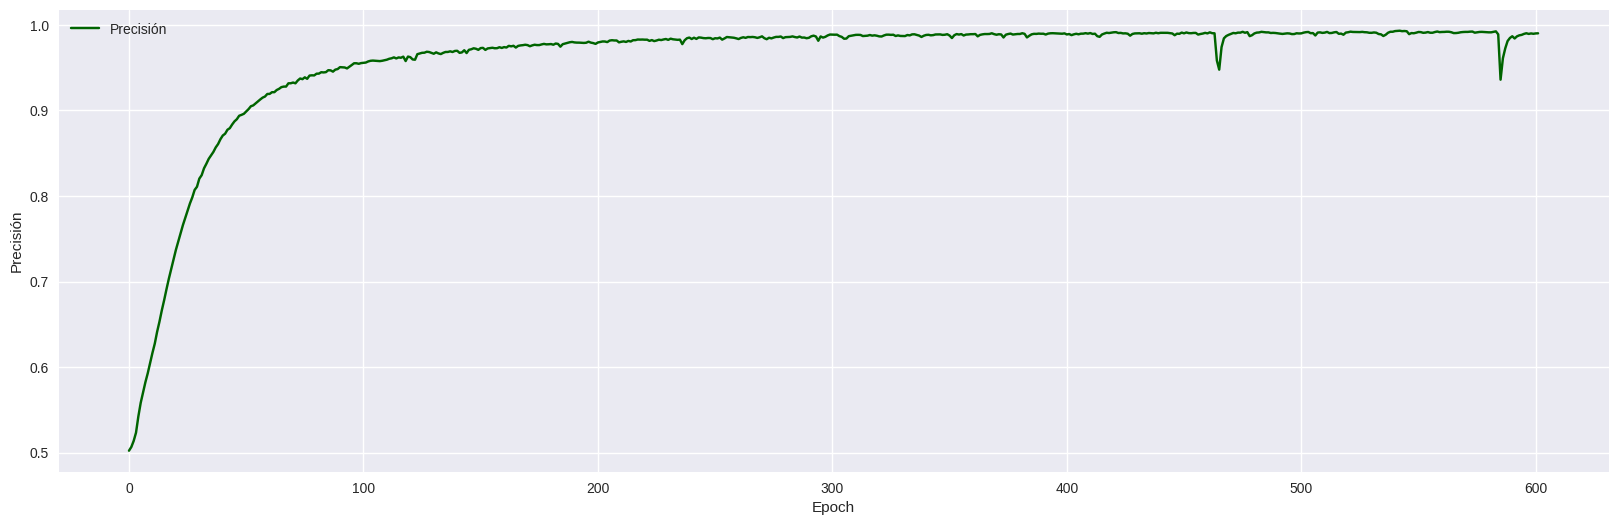

In [ ]:
draw_plot(history_training.history['accuracy'],"darkgreen", "Precisión")

<ipython-input-35-235b6aa75655>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn')


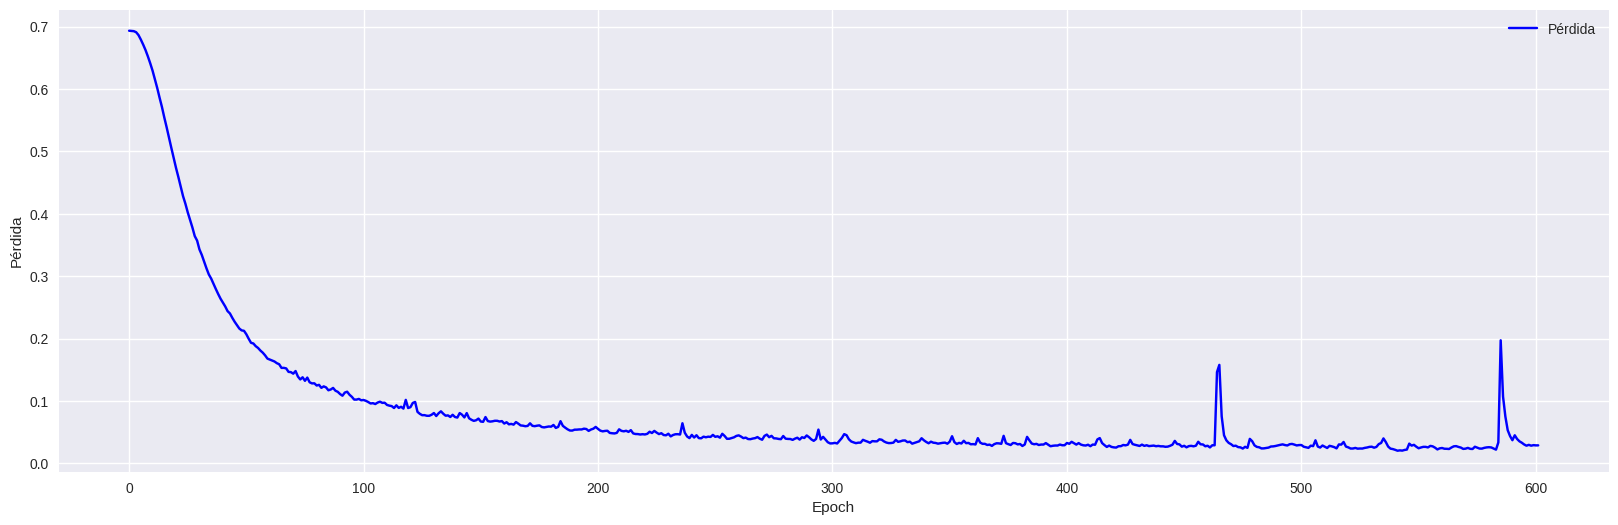

In [ ]:

draw_plot(history_training.history['loss'],"blue", "Pérdida")

In [ ]:
#@title Cargar datos de prueba
df_prueba = pd.read_csv('/content/sample_data/snli_1.0_test.csv')
columnas_prueba = ['sentence1','sentence2','gold_label']
df_prueba = df_prueba[columnas_prueba]
df_prueba.dropna(axis=0, inplace=True) #Se eliminan datos nulos
df_prueba.head()

,sentence1,sentence2,gold_label
0,This church choir sings to the masses as they ...,The church has cracks in the ceiling.,neutral
1,This church choir sings to the masses as they ...,The church is filled with song.,entailment
2,This church choir sings to the masses as they ...,A choir singing at a baseball game.,contradiction
3,"A woman with a green headscarf, blue shirt and...",The woman is young.,neutral
4,"A woman with a green headscarf, blue shirt and...",The woman is very happy.,entailment


In [ ]:
df_prueba = df_prueba.loc[df_prueba['gold_label'] != "-"]   #Se botan las filas que contengan - y neutral
df_prueba = df_prueba.loc[df_prueba['gold_label'] != "neutral"]
df_prueba.shape

(6605, 3)

In [ ]:
df_prueba = df_prueba.sample(frac = 1)
df_prueba["gold_label"] = (df_prueba["gold_label"] == "contradiction").astype(int)
df_prueba.head()

,sentence1,sentence2,gold_label
7066,3 Olympic winners posing for a photo on an adv...,Some girls are watching cartoons.,1
3250,"Two little girls, wearing pink hanging on a tube.",Two girls wearing blue sit on a couch.,1
1711,A swimmer is performing the breaststroke in an...,A swimmer is swimming,0
8932,The man wearing blue jean shorts is grilling.,The man is walking his dog.,1
2526,A man looks mysterious in a blue shirt and a r...,A woman cuts eggplant.,1


In [ ]:
df_prueba['sentence1'] = df_prueba['sentence1'].apply(limpiarTexto)
df_prueba['sentence2'] = df_prueba['sentence2'].apply(limpiarTexto)
df_prueba.head()

,sentence1,sentence2,gold_label
7066,olympic winners posing for a photo on an adve...,some girls are watching cartoons,1
3250,two little girls wearing pink hanging on a tube,two girls wearing blue sit on a couch,1
1711,a swimmer is performing the breaststroke in an...,a swimmer is swimming,0
8932,the man wearing blue jean shorts is grilling,the man is walking his dog,1
2526,a man looks mysterious in a blue shirt and a r...,a woman cuts eggplant,1


In [ ]:
df_prueba['sentence1'] = df_prueba['sentence1'].apply(remove_stopwords)
df_prueba['sentence2'] = df_prueba['sentence2'].apply(remove_stopwords)
df_prueba['sentence1'] = df_prueba['sentence1'].apply(stematizar)
df_prueba['sentence2'] = df_prueba['sentence2'].apply(stematizar)

In [ ]:
#@title Tokenización set de pruebas
sentencias_arreglo_prueba = np.asarray([df_prueba['sentence1'],df_prueba['sentence2']])
print(sentencias_arreglo_prueba)
sentencias_arreglo_prueba = sentencias_arreglo_prueba.reshape(-1,1)
sentencias_arreglo_prueba = sentencias_arreglo_prueba.reshape(sentencias_arreglo_prueba.shape[0])
tokenizar_prueba = Tokenizer(num_words=6000)
tokenizar_prueba.fit_on_texts(sentencias_arreglo_prueba)
texto_original_seq_prueba = tokenizar_prueba.texts_to_sequences(df_prueba['sentence1']) #Guarda un arreglo que en vez de palabras, posee índices de palabras
texto_original_prueba = pad_sequences(texto_original_seq_prueba) #Agrega padding para estandarizar el tamaño
hipotesis_seq_prueba = tokenizar_prueba.texts_to_sequences(df_prueba['sentence2'])
hipotesis_prueba = pad_sequences(hipotesis_seq_prueba, maxlen = texto_original_prueba.shape[1])
hipotesis_prueba.shape

[[' olymp winner pose photo advertis background'
  'two littl girl wear pink hang tube'
  'swimmer perform breaststrok indoor swim pool set competit' ...
  'man argyl shirt bend look goodi glass asian shop'
  'zaftig woman tube top jean danc outdoor guitarist behind'
  'person wear red shirt fall white surfboard']
 ['girl watch cartoon' 'two girl wear blue sit couch' 'swimmer swim' ...
  'adult shop gift' 'woman read book hous' 'person water']]


(6605, 45)

In [ ]:
encoder_prueba = LabelEncoder()
etiquetas_prueba = df_prueba['gold_label']
etiquetas_prueba = encoder_prueba.fit_transform(etiquetas_prueba)
etiquetas_prueba = to_categorical(etiquetas_prueba)
etiquetas_prueba.shape

(6605, 2)

In [ ]:
data_tokenizada_prueba = np.asarray([texto_original_prueba,hipotesis_prueba])
data_tokenizada_prueba = data_tokenizada_prueba.reshape(data_tokenizada_prueba.shape[1], 2, data_tokenizada_prueba.shape[2])
data_tokenizada_prueba.shape

<ipython-input-97-8f26af36c6b4>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_tokenizada_prueba = np.asarray([texto_original_prueba,hipotesis_prueba])


ValueError: ignored

In [ ]:
prediccion = m.predict(data_tokenizada_prueba, batch_size = 1024, verbose = 1)
prediccion

ValueError: ignored